# Differential Privacy with TensorFlow Privacy

In this exercise, you will use a differentially private version of stochastic gradient descent (SGD) to classify a binary subset of the MNIST dataset. As a baseline, you will use logistic regression with L2 regularization, and you will compare it to convolutional neural networks. Finally, you will search for a good trade-off between model utility (i.e. F1 score) and privacy (epsilon).

If you are not familiar with TensorFlow Privacy already, you may use this [**tutorial**](https://www.tensorflow.org/responsible_ai/privacy/tutorials/classification_privacy) to get an overview about the library or check out their [**GitHub repository**](https://github.com/tensorflow/privacy).

In [1]:
# imports
import numpy as np
np.random.seed(0)

from sklearn.metrics import accuracy_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split


import tensorflow as tf
from tensorflow.keras.datasets import mnist

import matplotlib.pyplot as plt
plt.style.use('seaborn-darkgrid')


import tensorflow_privacy
from tensorflow_privacy.privacy.analysis import compute_dp_sgd_privacy


2023-01-18 14:21:52.928056: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-18 14:21:53.075261: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-01-18 14:21:53.075299: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-01-18 14:21:53.988962: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

## Load and pre-process the dataset

* Just as in the last exercise, you should start by loading the **MNIST** dataset. You may use `tensorflow.keras.datasets.mnist`, which is included in the import statements above.

* Note that you need a **binarized** version of the MNIST dataset. Also, you need to keep only **2** classes out of 10, namely 5 and 8.
* Rescale the feature values such that each sample has **Euclidean norm** $≤ 1$.
* Plot some example images.

In [2]:
# load dataset using Keras

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

indexes_train = [i for i in range(len(y_train)) if y_train[i] in [5,8] ]
indexes_test = [i for i in range(len(y_test)) if y_test[i] in [5,8] ]

x_train, y_train = np.array([x_train[i] for i in indexes_train]), np.array([[y_train[i]] for i in indexes_train])


# normalize
x_train = x_train/255.

# binarize
x_train = np.where(x_train > 0.5, 1, 0)

#x_train = x_train.reshape((x_train.shape[0], x_train.shape[1]*x_train.shape[2]))

max = np.linalg.norm(x_train, axis=0).max()
x_train = np.divide(x_train, max)

# test-train-split
Xtrain, xtest, Ytrain, ytest = train_test_split(x_train, y_train, train_size = 10000)
Xtest, xrest, Ytest, yrest = train_test_split(Xtrain, Ytrain, train_size = 1000)

# reformulate y's
Ytrain = np.where(Ytrain > 5, 1, 0)
Ytest = np.where(Ytest > 5, 1, 0)


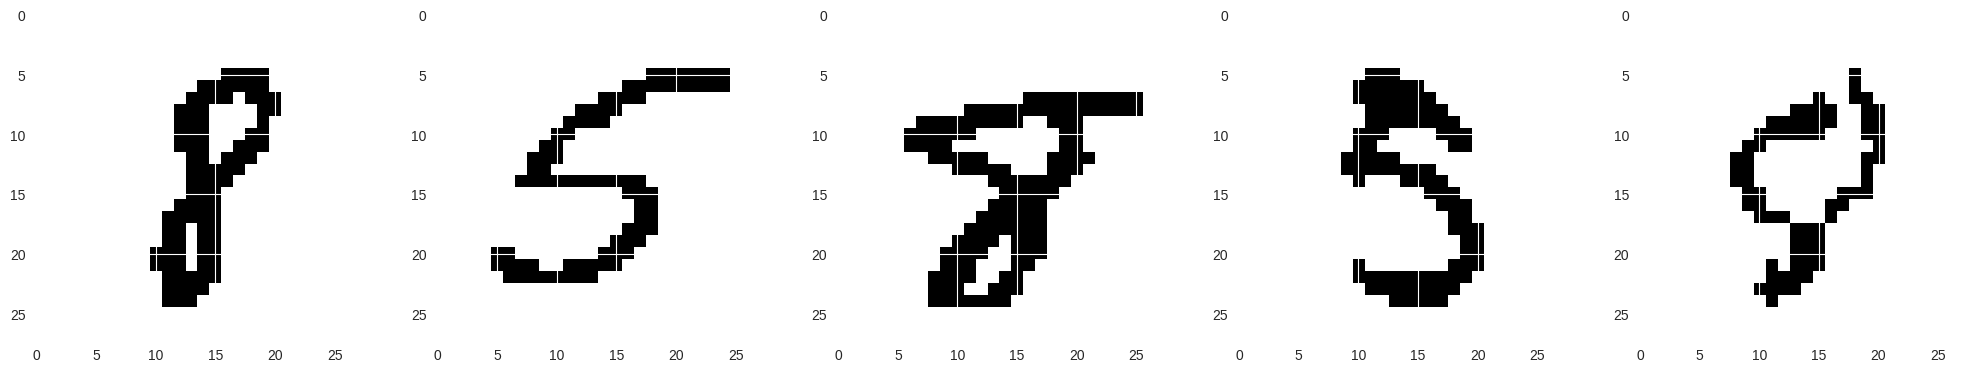

In [3]:
# plot some example images

idxs = np.random.choice(len(x_train), 5, replace=False)
fig, axs = plt.subplots(1,5,figsize=(25,25))
for idx, ax in zip(idxs, axs.flatten()):
    ax.imshow(x_train[idx])

## Setup, train and evaluate baseline model

* Setup a Logistic Regression model with L2 regularization and train it on the binarized MNIST data using **Differentially Private Stochastic Gradient Descent (DP-SGD)**. You may use `sklearn.linear_model.LogisticRegression` or an equivalent layer from TensorFlow (softmax/sigmoid). Use `tensorflow_privacy.DPKerasSGDOptimizer` as the optimizer (or the differentially private version of ADAM).

* Train the model on different privacy budgets: $\epsilon \in [0.1, 0.5, 1.0, 5.0, 10.0]$ with fixed $\delta = 0.0001$.

* Measure the classification performance using the $F_1$ score for each epsilon.

_Hint_: change the `noise_multiplier` hyperparameter in your `tensorflow_privacy.DPKerasSGDOptimizer` and observe how $\epsilon$ changes using `tensorflow_privacy.privacy.analysis.compute_dp_sgd_privacy`.

In [4]:
# use DP-SGD to train logistic regression with l2 regularization
lamb = 0.1
learning_rate=0.001


log_reg = tf.keras.Sequential()
log_reg.add(tf.keras.layers.Flatten())
log_reg.add(tf.keras.layers.Dense(1, kernel_regularizer=tf.keras.regularizers.l2(lamb), use_bias=False))
log_reg.add(tf.keras.layers.Activation("sigmoid"))

#log_reg.summary()

optimizer=tf.keras.optimizers.Adam(learning_rate)
loss = tf.keras.losses.BinaryCrossentropy()
log_reg.compile(optimizer=optimizer,
              loss=loss,
              metrics=['accuracy'])

hist = log_reg.fit(Xtrain, Ytrain, 
                  epochs=20, batch_size=128,
                  validation_split=0.2, 
                  shuffle=True,
                 verbose=True)

2023-01-18 14:22:06.917498: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-01-18 14:22:06.917692: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-01-18 14:22:06.917793: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (david-20hdcto1ww): /proc/driver/nvidia/version does not exist
2023-01-18 14:22:06.919043: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/20
63/63 [==============================] - 1s 6ms/step - loss: 0.7701 - accuracy: 0.4661 - val_loss: 0.7056 - val_accuracy: 0.6050
Epoch 2/20
63/63 [==============================] - 0s 4ms/step - loss: 0.6965 - accuracy: 0.5901 - val_loss: 0.6932 - val_accuracy: 0.5090
Epoch 3/20
63/63 [==============================] - 0s 4ms/step - loss: 0.6930 - accuracy: 0.5229 - val_loss: 0.6929 - val_accuracy: 0.5140
Epoch 4/20
63/63 [==============================] - 0s 4ms/step - loss: 0.6929 - accuracy: 0.5268 - val_loss: 0.6929 - val_accuracy: 0.5090
Epoch 5/20
63/63 [==============================] - 0s 4ms/step - loss: 0.6929 - accuracy: 0.5240 - val_loss: 0.6929 - val_accuracy: 0.5090
Epoch 6/20
63/63 [==============================] - 0s 4ms/step - loss: 0.6929 - accuracy: 0.5232 - val_loss: 0.6929 - val_accuracy: 0.5120
Epoch 7/20
63/63 [==============================] - 0s 4ms/step - loss: 0.6929 - accuracy: 0.5238 - val_loss: 0.6929 - val_accuracy: 0.5130
Epoch 8/20
63/63 [==

## Setup, train and evaluate CNN trained with DP-SGD

* Repeat the previous task, but instead of training L2-regularized Logistic Regression, you should train a 3-layer CNN using DP-SGD.

In [25]:
# use DP-SGD to train 3-layer CNN

cnn = tf.keras.Sequential()
cnn.add(tf.keras.layers.Conv2D(32,input_shape=(None, 28, 28), kernel_size=(3, 3), strides=2, padding='same', activation='relu'))
cnn.add(tf.keras.layers.Conv2D(64, kernel_size=(3, 3), strides=2, padding='same', activation='relu'))
cnn.add(tf.keras.layers.Conv2D(128, kernel_size=(3, 3), strides=2, padding='same', activation='relu'))

#cnn.add(tf.keras.layers.Flatten())
cnn.add(tf.keras.layers.Dense(32, activation='relu'))
cnn.add(tf.keras.layers.Dense(2))

cnn.build(input_shape=(None,28*28))

optimizer=tf.keras.optimizers.Adam(learning_rate)
loss = tf.keras.losses.BinaryCrossentropy()

cnn.compile(optimizer=optimizer,
              loss=loss,
              metrics=['accuracy'])

hist = cnn.fit(Xtrain, Ytrain, 
                  epochs=20, batch_size=128,
                  validation_split=0.2, 
                  shuffle=True,
                 verbose=True)

Epoch 1/20


ValueError: in user code:

    File "/home/david/.local/lib/python3.10/site-packages/keras/engine/training.py", line 1249, in train_function  *
        return step_function(self, iterator)
    File "/home/david/.local/lib/python3.10/site-packages/keras/engine/training.py", line 1233, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/david/.local/lib/python3.10/site-packages/keras/engine/training.py", line 1222, in run_step  **
        outputs = model.train_step(data)
    File "/home/david/.local/lib/python3.10/site-packages/keras/engine/training.py", line 1023, in train_step
        y_pred = self(x, training=True)
    File "/home/david/.local/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/home/david/.local/lib/python3.10/site-packages/keras/engine/input_spec.py", line 250, in assert_input_compatibility
        raise ValueError(

    ValueError: Exception encountered when calling layer 'sequential_19' (type Sequential).
    
    Input 0 of layer "conv2d_45" is incompatible with the layer: expected min_ndim=4, found ndim=3. Full shape received: (None, 28, 28)
    
    Call arguments received by layer 'sequential_19' (type Sequential):
      • inputs=tf.Tensor(shape=(None, 28, 28), dtype=float32)
      • training=True
      • mask=None


## Optional: Setup, train and evaluate CNN trained with "vanilla" SGD

* Retrain the CNN from the previous task with a "vanilla" (i. e. not differentially private) SGD optimizer, such as `tensorflow.keras.optimizers.SGD`.

In [ ]:
# use "vanilla" SGD to train 3-layer CNN

# [insert your code here]

## Plot results

* Plot curves for each model, with $\epsilon$ on the x-axis and your utility metric ($F_1$ score) on the y-axis.

* What do you observe?

In [ ]:
# line chart displaying privacy/utility trade-off

# [insert your code here]

**Bonus:** Try out the Gaussian-DP based accounting [here](https://github.com/tensorflow/privacy/blob/master/tensorflow_privacy/privacy/analysis/gdp_accountant.py)